In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
june = pd.read_csv('./data/listings_june.csv')

In [3]:
# Chained assignment to work with raw data. Must turn price to float and get bathroom count from bathroom_text
june = (
    june[
        [
            "id",
            "latitude",
            "longitude",
            "room_type",
            "accommodates",
            "bedrooms",
            "beds",
            # "price",
            # "availability_30",
            # "availability_60",
            # "availability_90",
            # "availability_365",
            "bathrooms_text",
        ]
    ]
    .astype({"room_type": "object"})
    .assign(
        # price_float=lambda x: x.price.str.replace("[\$,]", "", regex=True).astype(
        #     "float"
        # ),
        bathrooms_count=lambda x: x.bathrooms_text.str.extract("(\d+(?:\.\d+)?)")
        .fillna(0)
        .astype("float"),
        # year=lambda x: x.last_scraped.dt.year,
        # month=lambda x: x.last_scraped.dt.month,
        # day=lambda x: x.last_scraped.dt.day,
        # first_mo_occ=lambda x: (30 - x.availability_30),
        # second_mo_occ=lambda x: (60 - x.availability_60) - x.first_mo_occ,
        # third_mo_occ=lambda x: (90 - x.availability_90)
        # - x.first_mo_occ
        # - x.second_mo_occ,
        # month_1_revenue=lambda x: x.price_float * x.first_mo_occ,
        # month_2_revenue=lambda x: x.price_float * x.second_mo_occ,
        # month_3_revenue=lambda x: x.price_float * x.third_mo_occ,
        # total_90_day_revenue=lambda x: (90 - x.availability_90) * x.price_float,
    )
    .drop(columns=["bathrooms_text"])
    .fillna(0)
)

In [4]:
initial_len = len(june)

In [5]:
# def plot_distributions_continious_target(data, target):
#     nums = data.select_dtypes(include=np.number)
#     cats = data.select_dtypes(exclude=np.number)
#     for row, feature in enumerate(data.columns):
#         plt.figure(figsize=(12, 12))
#         plt.subplot(row + 1, 3, 1)
#         plt.title(f"{feature}'s Distribution")
#         sns.histplot(data=data, x=feature, bins=10)
#         if feature in nums:
#             plt.subplot(row + 1, 3, 2)
#             plt.title(f"{target} Range")
#             sns.boxplot(
#                 data=data,
#                 y=feature,
#             )
#             plt.subplot(row + 1, 3, 3)
#             plt.title(f"{target} vs. {feature}")
#             sns.scatterplot(
#                 data=data,
#                 x=target,
#                 y=feature,
#             )
#         plt.show()
#     pass


# plot_distributions_continious_target(june, "total_90_day_revenue")

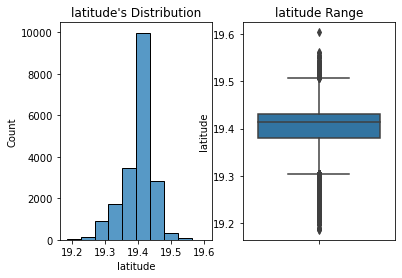

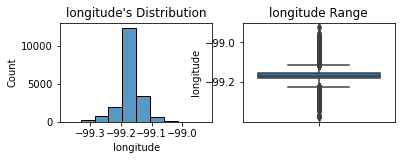

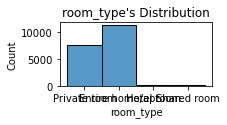

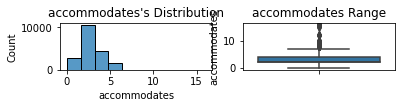

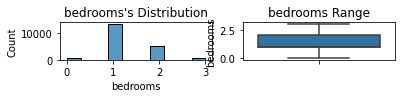

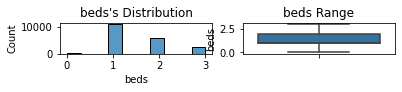

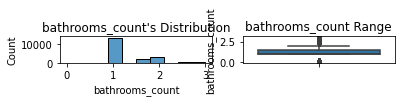

In [14]:
def plot_distributions_no_target(data):
    nums = data.select_dtypes(include=np.number)
    for row, feature in enumerate(data.columns):
        plt.subplot(row + 1, 2, 1)
        plt.title(f"{feature}'s Distribution")
        sns.histplot(data=data, x=feature, bins=10)
        if feature in nums:
            plt.subplot(row + 1, 2, 2)
            plt.title(f"{feature} Range")
            sns.boxplot(
                data=data,
                y=feature,
            )
        plt.show()
    pass

plot_distributions_no_target(june.drop(columns='id'))

In [7]:
def iqr(data, feature_list):
  upper_bounds = {}
  for feature in feature_list:
    q1 = data[feature].quantile(0.25)
    q3 = data[feature].quantile(0.75)
    iqr = (q3 - q1)*1.5
    upper_bounds[feature] = q3 + iqr
  
  return upper_bounds

In [8]:
outliers = ['bedrooms', 'beds', 'bathrooms_count']
iqrs = iqr(june, outliers)

In [9]:
# Drop Outliers
for feature in outliers:
  june = june[june[feature] < iqrs[feature]]

In [10]:
print(f"Rows dropped: {initial_len - len(june)}")

Rows dropped: 2207
